In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import re

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import mean_absolute_error

from braindecode.datasets import TUHAbnormal

from decode_tueg import add_ages_from_additional_sources

/tmp/ipykernel_30138/4217767312.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Wed Sep 20 09:26:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3D:00.0 Off |                  N/A |
| 27%   25C    P8     2W / 250W |   7567MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
data_path = '/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2.0.0/edf/'
n_jobs = 4

In [4]:
tuabn_train = TUHAbnormal(
    path=data_path,
    preload=False,
    add_physician_reports=True,
    n_jobs=n_jobs,
    target_name='age',
)

In [5]:
tuabn_train.description.pathological.value_counts()

False    1521
True     1472
Name: pathological, dtype: int64

In [6]:
TUHAbnormal._read_edf_header(tuabn_train.description[tuabn_train.description.subject == 4196].loc[0, 'path'])

b'0       00004196 F 01-JAN-1956 00004196 Age:53                                          '

In [7]:
for d in tuabn_train.datasets:
    d.description['report'] = TUHAbnormal._read_physician_report(
        d.description.path.replace('TUH_PRE', 'TUH').replace('.edf', '.txt'),
    )

In [8]:
tuabn_train = add_ages_from_additional_sources(tuabn_train)

In [9]:
tuabn_train.description

,path,version,year,month,day,subject,session,segment,train,pathological,report,age,gender,date_age,report_age
0,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,3,4196,3,0,False,False,CLINICAL HISTORY: Seizures.\nMEDICATIONS: Dil...,53,F,53,NaN
1,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,3,5864,1,0,False,False,"CLINICAL HISTORY: Schizophrenia, memory loss.\...",30,M,30,NaN
2,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,4,929,3,2,True,False,"CLINICAL HISTORY: Epilepsy, currently seizure...",39,F,39,38.0
3,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,4,5851,1,1,False,False,CLINICAL HISTORY: Sixty-five-year-old woman w...,65,F,65,NaN
4,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,9,5909,2,0,True,False,CLINICAL HISTORY: 32 year old male with episod...,32,M,32,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,7,6881,2,1,True,True,CLINICAL HISTORY: 50-year-old woman with a his...,51,F,51,50.0
2989,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,7,7757,3,1,True,False,"CLINICAL HISTORY: A 38-year-old woman, with u...",40,F,40,38.0
2990,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,7,9289,4,1,True,True,CLINICAL HISTORY: A 22-year-old with refractor...,22,M,22,22.0
2991,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,10,3240,2,1,True,False,CLINICAL HISTORY: A 55-year-old woman with re...,55,F,55,55.0


In [11]:
tuabn_train.description.subject.nunique()

2329

In [ ]:
c1 = (tuabn_train.description.age - tuabn_train.description.report_age).abs() < 2
c2 = (tuabn_train.description.age - tuabn_train.description.date_age).abs() < 2
c3 = (tuabn_train.description.date_age - tuabn_train.description.report_age).abs() < 2
ids = tuabn_train.description[c1 & c2 & c3].index.to_list()
tuabn_train_clean = tuabn_train.split([ids])['0']

In [10]:
tuabn_train_clean.description.subject.nunique()

In [12]:
# analyze ages of longitudinal datasets

In [13]:
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_absolute_error

from decode_tueg import (
    _add_ages_from_additional_sources, _reject_derivating_ages, 
    plot_age_source_comparisons, save_csv, save_fig)

In [14]:
ds_name = 'lnp'  # lnp, lnpp, lpnp
min_mins = 2
clean_age = False

In [15]:
with open(f'/home/jovyan/longitudinal/{ds_name}_{min_mins}_{clean_age}.pkl', 'rb') as f:
    ds = pickle.load(f)
if ds_name == 'lnp':
    with open(f'/home/jovyan/longitudinal/lp_{min_mins}_{clean_age}.pkl', 'rb') as f:
        ds2 = pickle.load(f)

In [16]:
description = ds.description
if ds_name == 'lnp':
    description = pd.concat([description, ds2.description])
    ds_name = 'lnp_lp'
description.shape

(22406, 20)

In [17]:
description['pathological'] = description['pathological'] == 1

In [12]:
import matplotlib.pyplot as plt

In [17]:
def scatter_age_sources(age_df, age_sources, palette):
    flip = False
    if flip:
        fig, ax_arr = plt.subplots(1, len(age_sources), figsize=(6*len(age_sources), 6))
    else:
        fig, ax_arr = plt.subplots(len(age_sources), 1, figsize=(6, 6*len(age_sources)))
    for i, (age1, age2) in enumerate(age_sources):
        ax = ax_arr[i] if len(age_sources) > 1 else ax_arr
        df = age_df
        df = df[~df[age1].isna()&~df[age2].isna()]
        offset = 10

        df_np = df[df.pathological==0]
        ax = sns.scatterplot(
            data=df_np,
            x=age1, y=age2, c=['b'],
            ax=ax, alpha=.5,
            label=f'False ({mean_absolute_error(df_np[age1], df_np[age2]):.2f} years MAE)',
        )
        df_p = df[df.pathological==1]
        ax = sns.scatterplot(
            data=df_p,
            x=age1, y=age2, c=['r'],
            ax=ax, alpha=.5,
            label=f'True ({mean_absolute_error(df_p[age1], df_p[age2]):.2f} years MAE)'
        )
        ax.plot([0, 100], [0, 100], c='k', linewidth=1)

        def age_to_label(age):
            if age == 'age':
                return '[EDF Header]'
            elif age == 'date_age':
                return '[Measurement Date – Birth Year]'
            elif age == 'report_age':
                return '[Medical Report]'
            else:
                raise ValueError

        ax.set_xlabel(f'Age [years] (n={len(df[age1])}) {age_to_label(age1)}')
        ax.set_ylabel(f'Age [years] (n={len(df[age2])}) {age_to_label(age2)}')
        #mae = mean_absolute_error(df[age1], df[age2])
        #ax.set_title(f'{mae:.2f} years MAE', y=1.01)
        if flip:
            ax.legend(title='Pathological', loc='best')#'lower right' if i != 1 else 'upper left')
        else:
            ax.legend(title='Pathological', loc='lower right' if i != 1 else 'upper left')
        mini = min(df[age1].min(), df[age2].min(), 0) - offset
        maxi = max(df[age1].max(), df[age2].max(), 100) + offset
        ax.set_xlim(mini, maxi)
        ax.set_ylim(mini, maxi)
    return ax_arr

In [43]:
save_figures = False

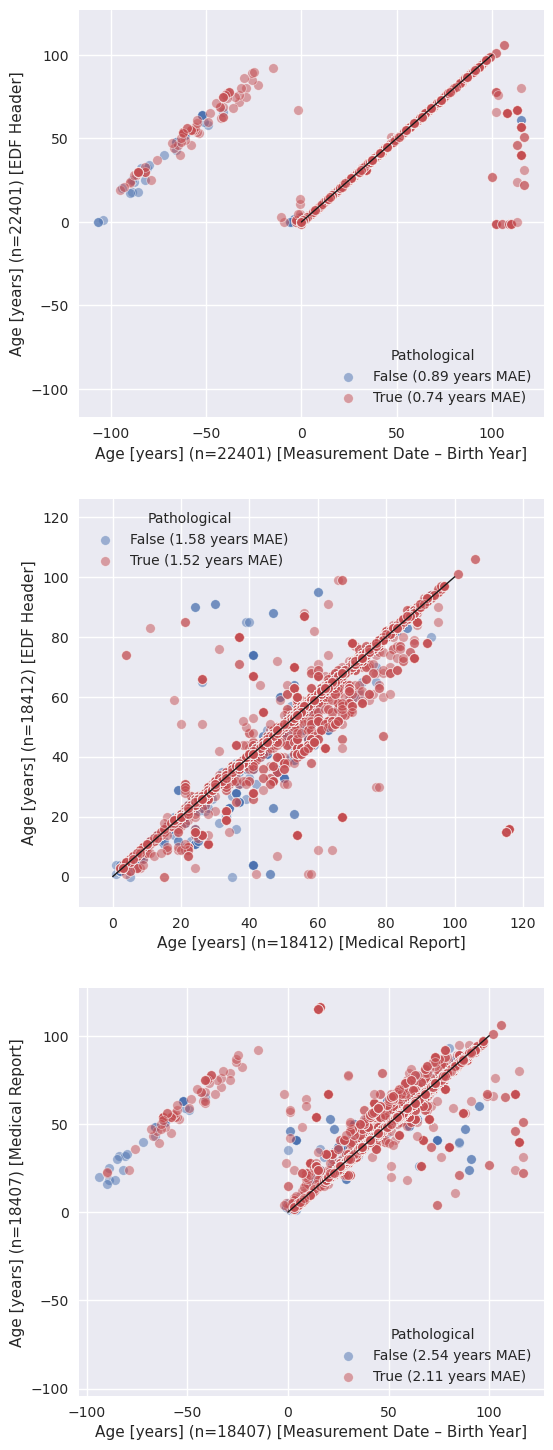

In [44]:
age_sources = [('date_age', 'age'), ('report_age', 'age'), ('date_age', 'report_age')]
ax = scatter_age_sources(description, age_sources, ['b', 'r'])
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{ds_name}_age_sources')